In [1]:
pip install scikeras

In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [4]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Assuming y_train and y_test are single columns and not DataFrames at this point
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])  # Assuming target_data is the column vector
    return np.array(X), np.array(y)

n_steps = 7  # Define the number of steps in your sequence
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)



In [5]:
def create_lstm_model(input_shape, optimizer='adam', lstm_units=50, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Assuming create_lstm_model and create_sequences are already defined

def run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=5):
    def lstm_objective(trial):
        # Initialize scalers
        scaler_x = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))

        # Normalize features and targets
        X_train_scaled = scaler_x.fit_transform(X_train)
        X_test_scaled = scaler_x.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

        # Create sequences
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

        # Hyperparameters
        #lstm_units = trial.suggest_categorical('lstm_units', [50, 100, 150])
        #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        #learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        #learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)
        lstm_units = trial.suggest_categorical('lstm_units', [50, 100])
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)

        # Model definition
        model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                                  lstm_units=lstm_units,
                                  dropout_rate=dropout_rate,
                                  optimizer=Adam(learning_rate=learning_rate))

        # Train the model
        model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

        # Evaluate
        train_pred_scaled = model.predict(X_train_seq)
        test_pred_scaled = model.predict(X_test_seq)
        train_pred = scaler_y.inverse_transform(train_pred_scaled)
        test_pred = scaler_y.inverse_transform(test_pred_scaled)

        # Metrics
        train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
        test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

        trial.set_user_attr('train_mae', train_mae)
        trial.set_user_attr('train_rmse', train_rmse)
        trial.set_user_attr('test_mae', test_mae)
        trial.set_user_attr('test_rmse', test_rmse)

        return test_rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(lstm_objective, n_trials=n_trials)

    best_trial = study.best_trial

    # Re-train the best model to get predictions for visualization
    best_params = best_trial.params
    model = create_lstm_model(
        input_shape=(n_steps, X_train_seq.shape[2]),
        lstm_units=best_params['lstm_units'],
        dropout_rate=best_params['dropout_rate'],
        optimizer=Adam(learning_rate=best_params['learning_rate'])
     )
    model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

    # Predict with the best model
    train_pred = scaler_y.inverse_transform(model.predict(X_train_seq))
    test_pred = scaler_y.inverse_transform(model.predict(X_test_seq))
    pred_list = {'train_pred': train_pred, 'test_pred': test_pred}

    results = {
        'Feature Engineering Method': 'Method Name',  # This will be replaced by the actual method name later
        'Best Trial Train MAE': best_trial.user_attrs['train_mae'],
        'Best Trial Train RMSE': best_trial.user_attrs['train_rmse'],
        'Best Trial Test MAE': best_trial.user_attrs['test_mae'],
        'Best Trial Test RMSE': best_trial.user_attrs['test_rmse'],
        'Best Params': best_trial.params
    }

    return results, pred_list


In [10]:

results_total = []
predictions_total = {}
# Placeholder for method names and corresponding data files
fe_methods_data = {
    'Without FE': ('./FE results/Train_original.csv', './FE results/Test_original.csv'),
    'Boruta': ('./FE results/Train_boruta.csv', './FE results/Test_boruta.csv'),
    'PCA': ('./FE results/Train_pca.csv', './FE results/Test_pca.csv'),
    't-SNE': ('./FE results/Train_tsne.csv', './FE results/Test_tsne.csv'),
}


for method_name, (train_file, test_file) in fe_methods_data.items():
    print(f'\n####### {method_name} #######')
    X_train = pd.read_csv(train_file).drop(columns=['Unnamed: 0', 'Date'])
    y_train = pd.read_csv("FE results/y_train.csv").drop(columns=['Unnamed: 0']).values.ravel()
    X_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0', 'Date'])
    y_test = pd.read_csv("FE results/y_test.csv").drop(columns=['Unnamed: 0']).values.ravel()

    results, pred_list = run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=10)
    results['Feature Engineering Method'] = method_name  # Set the method name in the results

    results_total.append(results)
    predictions_total[method_name] = pred_list  # Store predictions by method

# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

# Now, predictions_total contains the pred_list for each feature engineering method


[I 2024-03-18 21:39:20,923] A new study created in memory with name: no-name-3cdcaa27-30da-4cf7-8124-a9881aa2eea2



####### Without FE #######


<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:39:47,580] Trial 0 finished with value: 7.675060534647483 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1851360619886451, 'learning_rate': 0.0060550119606877055}. Best is trial 0 with value: 7.675060534647483.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-18 21:40:09,139] Trial 1 finished with value: 4.396618692803165 and parameters: {'lstm_units': 100, 'dropout_rate': 0.11400684301835186, 'learning_rate': 0.00889963338489934}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:40:35,615] Trial 2 finished with value: 12.14078596643981 and parameters: {'lstm_units': 50, 'dropout_rate': 0.19768273701120068, 'learning_rate': 0.0016408883681908832}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:40:57,549] Trial 3 finished with value: 6.454964052842749 and parameters: {'lstm_units': 100, 'dropout_rate': 0.16625920715239717, 'learning_rate': 0.0010696793162971278}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-18 21:41:18,905] Trial 4 finished with value: 6.120548406042657 and parameters: {'lstm_units': 100, 'dropout_rate': 0.18880877754095904, 'learning_rate': 0.0034230457604036897}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-18 21:41:44,090] Trial 5 finished with value: 8.169880614239622 and parameters: {'lstm_units': 50, 'dropout_rate': 0.16330576853478243, 'learning_rate': 0.0017762778951619712}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:42:10,257] Trial 6 finished with value: 7.364079600046778 and parameters: {'lstm_units': 100, 'dropout_rate': 0.18872663832355302, 'learning_rate': 0.006264037356024561}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:42:32,332] Trial 7 finished with value: 6.484854499915615 and parameters: {'lstm_units': 100, 'dropout_rate': 0.13256755123697772, 'learning_rate': 0.0013385570333684868}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:42:58,489] Trial 8 finished with value: 7.861424366641056 and parameters: {'lstm_units': 50, 'dropout_rate': 0.15041665194134562, 'learning_rate': 0.009601959589626749}. Best is trial 1 with value: 4.396618692803165.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:43:24,777] Trial 9 finished with value: 10.688989665168211 and parameters: {'lstm_units': 100, 'dropout_rate': 0.19751723011848354, 'learning_rate': 0.0023533645392746208}. Best is trial 1 with value: 4.396618692803165.


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:43:51,602] A new study created in memory with name: no-name-32e5fc2c-b2d0-42a7-ad8e-be62bc5a8552



####### Boruta #######


<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:44:13,471] Trial 0 finished with value: 5.852925236345529 and parameters: {'lstm_units': 50, 'dropout_rate': 0.11603714594027888, 'learning_rate': 0.006280995291864297}. Best is trial 0 with value: 5.852925236345529.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:44:35,572] Trial 1 finished with value: 5.4451097841101435 and parameters: {'lstm_units': 100, 'dropout_rate': 0.17981987110224507, 'learning_rate': 0.004541139639774024}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:45:00,686] Trial 2 finished with value: 8.074332235673262 and parameters: {'lstm_units': 100, 'dropout_rate': 0.10954597464968774, 'learning_rate': 0.0010439402144321924}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:45:23,039] Trial 3 finished with value: 5.556024466529811 and parameters: {'lstm_units': 50, 'dropout_rate': 0.164146052335251, 'learning_rate': 0.0027282926008649626}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:45:45,134] Trial 4 finished with value: 6.873099451726205 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1653943028319219, 'learning_rate': 0.004113584905950238}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:46:07,162] Trial 5 finished with value: 8.147654931214966 and parameters: {'lstm_units': 50, 'dropout_rate': 0.13950818007140728, 'learning_rate': 0.003948392132983551}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:46:33,674] Trial 6 finished with value: 8.424243181729796 and parameters: {'lstm_units': 100, 'dropout_rate': 0.17660786781611895, 'learning_rate': 0.001734448856862071}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:46:55,939] Trial 7 finished with value: 12.95881969272651 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1933750196107294, 'learning_rate': 0.001246525205498452}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:47:22,164] Trial 8 finished with value: 6.081284391723288 and parameters: {'lstm_units': 100, 'dropout_rate': 0.13643841550874014, 'learning_rate': 0.008872918458802585}. Best is trial 1 with value: 5.4451097841101435.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:47:48,974] Trial 9 finished with value: 10.020564271881486 and parameters: {'lstm_units': 50, 'dropout_rate': 0.14008064760516908, 'learning_rate': 0.0026870859624504883}. Best is trial 1 with value: 5.4451097841101435.


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:48:10,935] A new study created in memory with name: no-name-754d17aa-045e-4314-9420-f81c60890359



####### PCA #######


<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-18 21:48:37,980] Trial 0 finished with value: 82.09960134996825 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1125949462802194, 'learning_rate': 0.0014517903388978428}. Best is trial 0 with value: 82.09960134996825.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-18 21:49:07,493] Trial 1 finished with value: 77.62616587195318 and parameters: {'lstm_units': 50, 'dropout_rate': 0.14790829460616006, 'learning_rate': 0.00452417994480798}. Best is trial 1 with value: 77.62616587195318.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:49:33,594] Trial 2 finished with value: 79.56607930982922 and parameters: {'lstm_units': 50, 'dropout_rate': 0.12161866615223973, 'learning_rate': 0.0024174125666301125}. Best is trial 1 with value: 77.62616587195318.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-18 21:50:00,405] Trial 3 finished with value: 75.19972830367723 and parameters: {'lstm_units': 50, 'dropout_rate': 0.17650773829715544, 'learning_rate': 0.0012474069118914707}. Best is trial 3 with value: 75.19972830367723.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:50:26,839] Trial 4 finished with value: 75.64350057228567 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1266610926874025, 'learning_rate': 0.006498424541763594}. Best is trial 3 with value: 75.19972830367723.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:50:48,750] Trial 5 finished with value: 78.52497412852766 and parameters: {'lstm_units': 50, 'dropout_rate': 0.17526320976801926, 'learning_rate': 0.003700531975304713}. Best is trial 3 with value: 75.19972830367723.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:51:14,938] Trial 6 finished with value: 77.71581312179511 and parameters: {'lstm_units': 50, 'dropout_rate': 0.17565816163996248, 'learning_rate': 0.00551762887671457}. Best is trial 3 with value: 75.19972830367723.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:51:36,693] Trial 7 finished with value: 78.90126865618402 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1648457129745953, 'learning_rate': 0.0076488452280271905}. Best is trial 3 with value: 75.19972830367723.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:51:59,290] Trial 8 finished with value: 79.80121584562394 and parameters: {'lstm_units': 50, 'dropout_rate': 0.10647795330658819, 'learning_rate': 0.005914540558721394}. Best is trial 3 with value: 75.19972830367723.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:52:20,825] Trial 9 finished with value: 79.11528577636926 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1339174021992212, 'learning_rate': 0.007145258373514452}. Best is trial 3 with value: 75.19972830367723.


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:52:47,642] A new study created in memory with name: no-name-f29b0588-036d-4f80-a1d1-ea6479f65d2a



####### t-SNE #######


<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:53:13,774] Trial 0 finished with value: 73.42873654189701 and parameters: {'lstm_units': 50, 'dropout_rate': 0.11276517208799665, 'learning_rate': 0.008906906682418456}. Best is trial 0 with value: 73.42873654189701.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-18 21:53:40,037] Trial 1 finished with value: 74.02968324932371 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1802673542621124, 'learning_rate': 0.0017909571985341131}. Best is trial 0 with value: 73.42873654189701.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:54:06,845] Trial 2 finished with value: 73.384887788097 and parameters: {'lstm_units': 50, 'dropout_rate': 0.19231048627999686, 'learning_rate': 0.0012546817859520885}. Best is trial 2 with value: 73.384887788097.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:54:29,040] Trial 3 finished with value: 76.90926283507774 and parameters: {'lstm_units': 100, 'dropout_rate': 0.19651424318622074, 'learning_rate': 0.006710442908420123}. Best is trial 2 with value: 73.384887788097.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:54:51,750] Trial 4 finished with value: 71.86300150652852 and parameters: {'lstm_units': 50, 'dropout_rate': 0.17057363594146724, 'learning_rate': 0.004716027440213127}. Best is trial 4 with value: 71.86300150652852.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:55:13,921] Trial 5 finished with value: 75.03099480521429 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1055831904079579, 'learning_rate': 0.004549888317772171}. Best is trial 4 with value: 71.86300150652852.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:55:36,082] Trial 6 finished with value: 73.92779254418484 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1619884685472542, 'learning_rate': 0.006236141001957616}. Best is trial 4 with value: 71.86300150652852.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:55:58,106] Trial 7 finished with value: 74.71203426098008 and parameters: {'lstm_units': 50, 'dropout_rate': 0.12422498693297479, 'learning_rate': 0.0033772809138849823}. Best is trial 4 with value: 71.86300150652852.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:56:24,286] Trial 8 finished with value: 73.36127212323515 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1674568041330664, 'learning_rate': 0.009403266090117433}. Best is trial 4 with value: 71.86300150652852.
<ipython-input-5-e6551b0d77a3>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-5-e6551b0d77a3>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-18 21:56:46,795] Trial 9 finished with value: 78.6589260023241 and parameters: {'lstm_units': 50, 'dropout_rate': 0.19088467556751845, 'learning_rate': 0.00725440983900388}. Best is trial 4 with value: 71.86300150652852.


9/9 [==============================] - 0s 3ms/step
  Feature Engineering Method  Best Trial Train MAE  Best Trial Train RMSE  \
0                 Without FE              2.533997               3.665990   
1                     Boruta              2.337078               3.433205   
2                        PCA              3.534650               4.648469   
3                      t-SNE              3.989183               5.705232   

   Best Trial Test MAE  Best Trial Test RMSE  \
0             3.649837              4.396619   
1             4.468751              5.445110   
2            70.236055             75.199728   
3            64.640855             71.863002   

                                         Best Params  
0  {'lstm_units': 100, 'dropout_rate': 0.11400684...  
1  {'lstm_units': 100, 'dropout_rate': 0.17981987...  
2  {'lstm_units': 50, 'dropout_rate': 0.176507738...  
3  {'lstm_units': 50, 'dropout_rate': 0.170573635...  


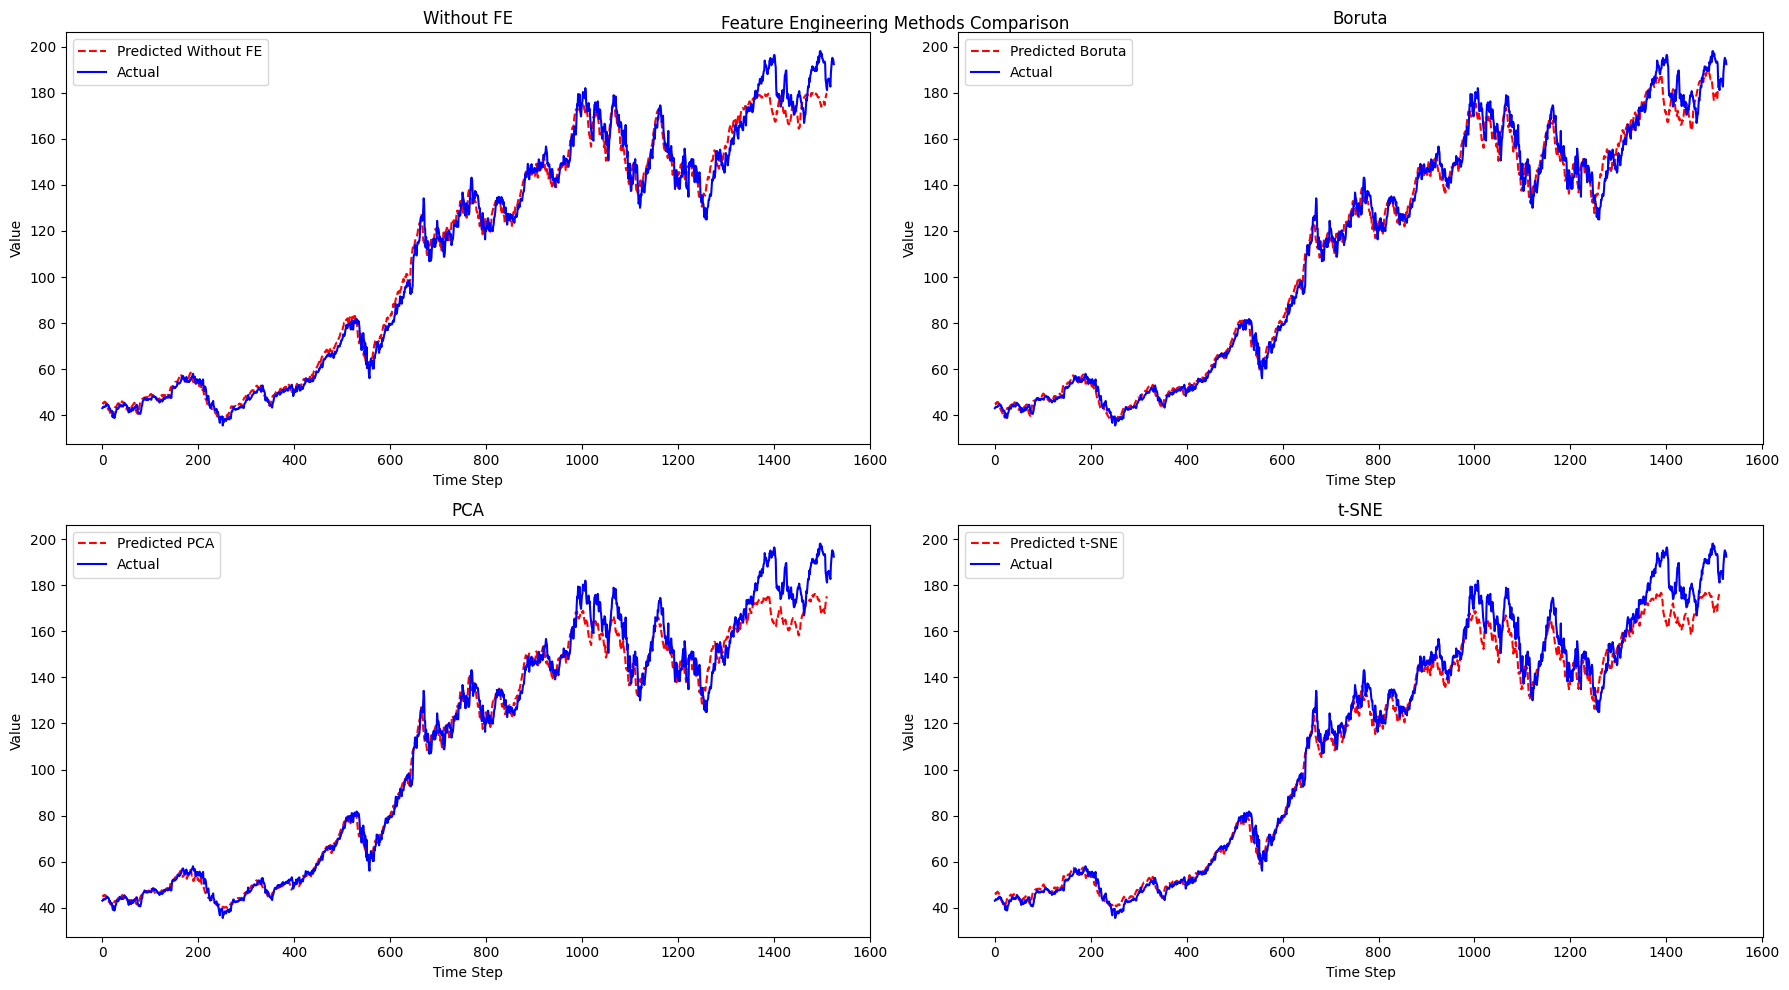

In [12]:
import matplotlib.pyplot as plt

# Assuming y_actual is prepared outside this snippet as suggested.
y_actual = np.concatenate((y_train, y_test), axis=0)

plt.figure(figsize=(18, 10))

for i, (method_name, pred_list) in enumerate(predictions_total.items(), start=1):
    # Concatenate train and test predictions for continuity
    predictions = np.concatenate((pred_list['train_pred'], pred_list['test_pred']), axis=0)

    # Plot
    plt.subplot(2, 2, i)
    plt.plot(predictions, label=f'Predicted {method_name}', linestyle='--', marker='', color='red')
    plt.plot(y_actual, label='Actual', linestyle='-', marker='', color='blue')
    plt.title(f'{method_name}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.suptitle('Feature Engineering Methods Comparison')
plt.show()


In [11]:
results_total

[{'Feature Engineering Method': 'Without FE',
  'Best Trial Train MAE': 2.5339967484477963,
  'Best Trial Train RMSE': 3.665990368249918,
  'Best Trial Test MAE': 3.6498371438438997,
  'Best Trial Test RMSE': 4.396618692803165,
  'Best Params': {'lstm_units': 100,
   'dropout_rate': 0.11400684301835186,
   'learning_rate': 0.00889963338489934}},
 {'Feature Engineering Method': 'Boruta',
  'Best Trial Train MAE': 2.337078165383433,
  'Best Trial Train RMSE': 3.4332046718863127,
  'Best Trial Test MAE': 4.468751165767728,
  'Best Trial Test RMSE': 5.4451097841101435,
  'Best Params': {'lstm_units': 100,
   'dropout_rate': 0.17981987110224507,
   'learning_rate': 0.004541139639774024}},
 {'Feature Engineering Method': 'PCA',
  'Best Trial Train MAE': 3.5346496176709064,
  'Best Trial Train RMSE': 4.648468844827865,
  'Best Trial Test MAE': 70.23605533983529,
  'Best Trial Test RMSE': 75.19972830367723,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.17650773829715544,
   'learnin

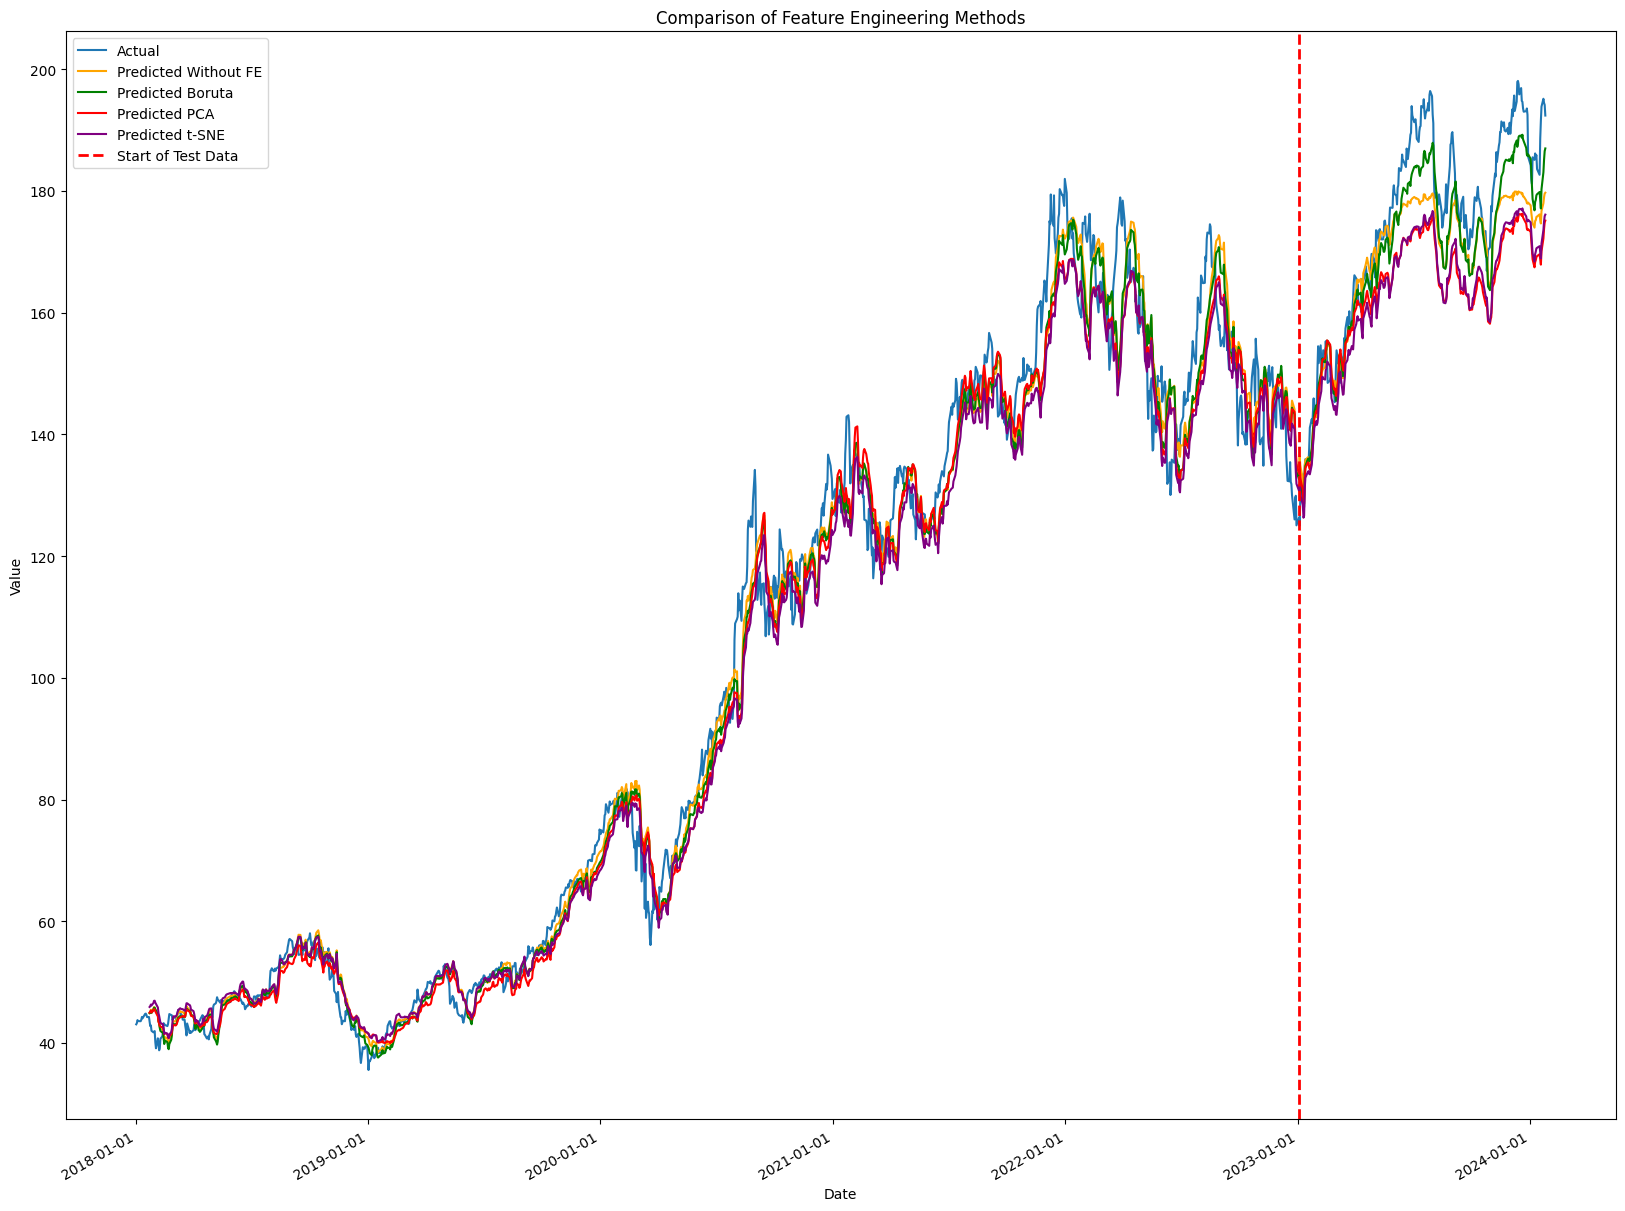

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Convert 'dates' to a Pandas DatetimeIndex for plotting if it's not already
dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)
#plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}',color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis with dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()
